In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [155]:
results_all = dict()

results_all['webp'] = {
    'quality': [1, 8, 16, 32, 64, 80, 96],
    'bpp': [0.233027, 0.361705, 0.466873, 0.661756, 1.028537, 1.418366, 3.293082],
    'acc': [46.67, 56.37, 61.34, 67.39, 70.546, 72.138, 73.956],
    'acc-ft': [68.06, 71.01, 72.41, 73.95, 75.25, 75.74, None],
}
results_all['wacv2022_code'] = {
    'acc': [0.5737,    0.71608,  0.74226,  0.75096,  0.75314,  0.75632,  0.75928,  0.75916],
    'bpp': [0.1465677, 0.330722, 0.595901, 0.886827, 1.311912, 1.831621, 2.592045, 3.653037],
    # 'acc': [0.5737,    0.71608,  0.74226,  0.75096,  0.75314,  0.75632,],
    # 'bpp': [0.1465677, 0.330722, 0.595901, 0.886827, 1.311912, 1.831621,],
    'beta': [1.28,     0.64,     0.32,     0.16,     0.08,     0.04,     0.02,     0.01]
}
results_all['wacv2022_code']['acc'] = [f*100 for f in results_all['wacv2022_code']['acc']]

results_all['ours_s8_medium'] = {
    # 'bpp': [0.1102, 0.162, 0.2124, 0.3188, 0.442, 0.7213, 1.194, 1.576, 2.295],
    # 'acc': [68.77, 70.6, 71.53, 72.93, 73.64, 74.88, 75.1, 75.18, 75.32],
    'bpp': [0.1102, 0.162, 0.2124, 0.3188, 0.442, 0.7213, 1.194, 1.576],
    'acc': [68.77, 70.6, 71.53, 72.93, 73.64, 74.88, 75.1, 75.18],
}
results_all['ours_s8_small'] = {
    'bpp': [0.09303, 0.1125, 0.1443, 0.1754, 0.2143, 0.3236, 0.4604, 0.7328, 1.222, 2.293],
    'acc': [67.03, 68.19, 69.25, 69.85, 71.14, 72.63, 73.55, 74.72, 75.17, 75.27],
}
results_all['ours_s8_tiny'] = {
    'bpp': [0.1117, 0.1372, 0.1786, 0.2829, 0.4206, 0.5508, 0.7209, 1.178, 1.747],
    'acc': [61.99, 63.95, 67.83, 70.69, 73.06, 73.84, 74.07, 74.64, 74.93],
}
results_all['ours_s8_tiny_enc'] = {
    'bpp': [0.1216, 0.1596, 0.2154, 0.258, 0.4026, 0.5432, 0.7719, 1.106, 1.689],
    'acc': [45.04, 55.28, 64.53, 66.60, 69.89, 70.78, 73.21, 73.35, 74.48],
}

5.552426227303441

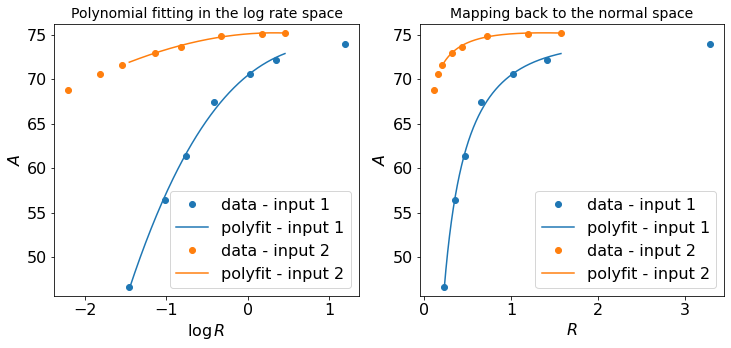

In [165]:
def _poly_of_log_integral(poly, xmin, xmax, N=1000):
    degree = poly.shape[0] - 1
    x = np.linspace(xmin, xmax, num=N)
    y = sum([poly[i] * np.log(x)**(degree-i) for i in range(degree + 1)])
    assert y.shape == (N,)
    # approximated area under the curve (ie, definite integral)
    auc = np.sum(y) * float(1/N)
    return auc, (x, y)


def polynomial_fit(stats):
    bpp = stats['bpp']
    acc = stats['acc']
    logb = np.log(bpp)

    fig1, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(logb, acc, label='data',
               marker='.', markersize=12, linestyle='None', color='black')
    ax[1].plot(bpp, acc, label='data',
               marker='.', markersize=12, linestyle='None', color='black')

    for degree in [3]:
        poly = np.polyfit(logb, acc, deg=degree)
        # print(poly)
        x = np.linspace(min(logb)-0.5, max(logb)+0.2, num=200)
        ax[0].plot(x, np.polyval(poly, x), label=f'degree={degree}',
                   linestyle='-')

        # x = np.linspace(0.1, max(bpp)+0.5, num=200)
        # y = sum([poly[d] * np.log(x)**(degree-d) for d in range(degree + 1)])
        # ax[1].plot(x, y, label=f'degree={degree}',
        #             linestyle='-')
        auc = _poly_of_log_integral(poly, 0.1, max(bpp)+0.5, N=100)
        print(auc)

        # y = sum([poly[d] * x**(degree-d) for d in range(degree + 1)])
        # plt.plot(x, y, label=f'degree={degree} my',
        #          linestyle='--')
    # plt.xlim(min(logb)-0.2, max(logb)+0.2)
    plt.setp(ax, ylim=(40, 77))
    # plt.xlabel('log-bpp')
    # plt.ylabel('Top-1 accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_xlabel('$\log R$')
    ax[0].set_ylabel('$A$')
    ax[0].set_title('Polynomial fitting in the log rate space', fontdict = {'fontsize' : 14})
    ax[1].legend(loc='lower right')
    ax[1].set_xlabel('$R$')
    ax[1].set_ylabel('$A$')
    ax[1].set_title('Mapping back to the normal space', fontdict = {'fontsize' : 14})

def bd_accuracy(stats1, stats2, visualize=False):
    bpp1 = stats1['bpp']
    acc1 = stats1['acc']
    name1 = stats1.get('name', 'input 1')
    bpp2 = stats2['bpp']
    acc2 = stats2['acc']
    name2 = stats2.get('name', 'input 2')

    logb1 = np.log(bpp1)
    logb2 = np.log(bpp2)

    degree = 3
    poly1 = np.polyfit(logb1, acc1, deg=degree)
    poly2 = np.polyfit(logb2, acc2, deg=degree)

    bppmin = max(min(bpp1), min(bpp2))
    bppmax = min(max(bpp1), max(bpp2))
    auc1, (_x1,_y1) = _poly_of_log_integral(poly1, xmin=bppmin, xmax=bppmax, N=10000)
    auc2, (_x2,_y2) = _poly_of_log_integral(poly2, xmin=bppmin, xmax=bppmax, N=10000)

    bd_acc = (auc2 - auc1) / (bppmax - bppmin)

    if visualize:
        x = np.linspace(np.log(bppmin), np.log(bppmax), num=200)
        fig1, ax = plt.subplots(1, 2, figsize=(12,5))
        plt.setp(ax, ylim=(min(min(acc1), min(acc2))-1, max(max(acc1), max(acc2))+1))
        # left figure: log space
        l1 = ax[0].plot(logb1, acc1, label=f'data - {name1}', marker='.', markersize=12, linestyle='none')
        ax[0].plot(x, np.polyval(poly1, x), label=f'polyfit - {name1}', color=l1[0].get_color())
        l2 = ax[0].plot(logb2, acc2, label=f'data - {name2}', marker='.', markersize=12, linestyle='none')
        ax[0].plot(x, np.polyval(poly2, x), label=f'polyfit - {name2}', color=l2[0].get_color())
        ax[0].set_xlabel('$\log R$')
        ax[0].set_ylabel('$A$')
        ax[0].set_title('Polynomial fitting in the log rate space', fontdict = {'fontsize' : 14})
        ax[0].legend(loc='lower right')
        # right figure: normal space
        l1 = ax[1].plot(bpp1,  acc1, label=f'data - {name1}', marker='.', markersize=12, linestyle='none')
        ax[1].plot(_x1, _y1, label=f'polyfit - {name1}', color=l1[0].get_color())
        l2 = ax[1].plot(bpp2,  acc2, label=f'data - {name2}', marker='.', markersize=12, linestyle='none')
        ax[1].plot(_x2, _y2, label=f'polyfit - {name2}', color=l2[0].get_color())
        ax[1].set_xlabel('$R$')
        ax[1].set_ylabel('$A$')
        ax[1].set_title('Mapping back to the normal space', fontdict = {'fontsize' : 14})
        ax[1].legend(loc='lower right')
    else:
        pass

    return bd_acc

# for k in results_all.keys():
#     polynomial_fit(results_all[k])
# polynomial_fit(results_all['webp'])
# polynomial_fit(results_all['wacv2022_code'])

# bd_accuracy(results_all['wacv2022_code'], results_all['ours_s8_medium'], visualize=True)
bd_accuracy(results_all['webp'], results_all['ours_s8_medium'], visualize=True)

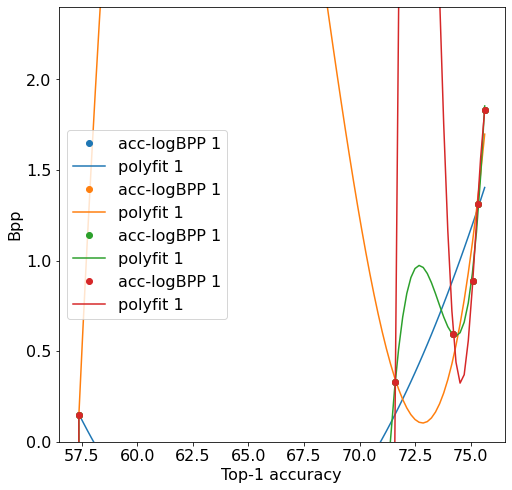

In [139]:
def bd_rate(stats1, stats2, degree=3):
    bpp1 = stats1['bpp']
    acc1 = stats1['acc']
    bpp2 = stats2['bpp']
    acc2 = stats2['acc']

    flag = False
    flag = True
    if flag:
        b1 = bpp1
        b2 = bpp2
    else:
        b1 = np.log(bpp1)
        b2 = np.log(bpp2)

    # fit each curve by a polynomial
    p1 = np.polyfit(acc1, b1, deg=degree)
    p2 = np.polyfit(acc2, b2, deg=degree)

    l1 = plt.plot(acc1, b1, label='acc-logBPP 1',
                    marker='.', markersize=12, linestyle='None')
    # l2 = plt.plot(acc2, b2, label='acc-logBPP 2',
    #                 marker='.', markersize=12, linestyle='None')
    # x = np.linspace(min_acc, max_acc, num=100)
    x = np.linspace(min(min(acc1), min(acc2)), max(max(acc1), max(acc2)), num=100)
    # x = np.linspace(min_acc-10, max_acc+10, num=100)
    plt.plot(x, np.polyval(p1, x), label='polyfit 1',
                linestyle='-', color=l1[0].get_color())
    # plt.plot(x, np.polyval(p2, x), label='polyfit 2',
    #             linestyle='-', color=l2[0].get_color())
    if flag:
        plt.ylim(0.0, 2.4)
        plt.ylabel('Bpp')
    else:
        plt.ylim(-2.5, 1.0)
        plt.ylabel('log-Bpp')
    plt.xlabel('Top-1 accuracy')
    plt.legend()

plt.figure(figsize=(8,8))
for d in [2,3,4,5]:
    bd_rate(results_all['wacv2022_code'], results_all['ours_s8_medium'], degree=d)

In [125]:
x = np.random.randn(6)
y = 1.4 * x**3 + 3.2 * x**2 - 0.8 * x + 7
np.polyfit(x, y, deg=3)

AttributeError: 'numpy.ndarray' object has no attribute 'power'